<h1> Latest craigslist used car data as of July 15th, 2019 </h1> 
<h3> Taking a closer look at low priced used cars on craiglist</h3>
Focused on cars worth less than &dollar;20,000. <br>
<a href="https://www.kaggle.com/austinreese/craigslist-carstrucks-data">Data on Kaggle</a> <br>
<a href="https://review.udacity.com/#!/rubrics/1507/view">rubric</a>

<p>
    <h4>CRISP-DM approach to Exploratory Data Analysis</h4>
<ol>
  <li>Business Understanding</li>
    <ol>
        <li>What is the most common car for sale?</li>
        <li>What car gives the best value? Balance between price and mileage</li>
        <li>Where can we find the best value cars?</li>
    </ol>
  <li>Data Understanding</li>
    <ul>
      <li>547,000 lines of cars for sale</li>
      <li>each line has a unique car for sale</li>
      <li>22 columns</li>
      <li>columns of interest: price, location, description, year, manufacturer, make, odometer, desc</li>
      <li>take a look at cars priced less than &dollar;20,000. Research shows this is the popular price range for buying and selling cars (car flipping). Clean up the data and find insights for the questions above.</li>
    </ul>
  <li>Prepare Data</li>
    <ul>
      <li>eliminate odometer reading of zero, it's incorrect. Ex: Row 21365</li>
      <li>eliminate cars worth 0 or 1 dollars - ad clickbait</li>
      <li>remove postings about leases by removing year greater than 2015 and price less than 4000</li>
      <li>eliminate cars worth more than 20k, not relavant to car flipping focus</li>
      <li>eliminate salvaged titles</li>
      <li>inaccurate odometer readings due to used car dealerships and people not listing correctly, need to eliminate low mileage</li>
      <li>some lines are cars wanted ads. need to eliminate these. search for 'wanted', 'looking to buy', 'I buy cars' in the desc</li>
      <li>manufacturer column has missing data. Fill it in using data from the 'make' column</li>
      <li>if two descriptions match, eliminate one. duplicate entry</li>
    </ul>
  <li>Data Modeling</li>
  <li>Evaluate Results</li>
  <li>Deploy</li>
</ol>
    

In [441]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
os.environ['PROJ_LIB'] = '/Users/vranu/miniconda2/share/proj'
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import plotly

plotly.offline.init_notebook_mode()



In [446]:
def plot_bar_chart(df, col):
    '''
    input: a dataframe, and a column for plotting
    returns: a bar chart 
    '''
    df[col].value_counts().plot(kind='bar',  figsize=(15,5))

In [308]:
df = pd.read_csv('craigslistVehicles.csv')


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386378 entries, 2 to 547762
Data columns (total 22 columns):
url             386378 non-null object
city            386378 non-null object
city_url        386378 non-null object
price           386378 non-null int64
year            386375 non-null float64
manufacturer    386378 non-null object
make            386378 non-null object
condition       222776 non-null object
cylinders       247762 non-null object
fuel            383345 non-null object
odometer        386378 non-null float64
title_status    386378 non-null object
transmission    383263 non-null object
VIN             268578 non-null object
drive           303114 non-null object
size            137798 non-null object
type            310935 non-null object
paint_color     287767 non-null object
image_url       386378 non-null object
desc            386377 non-null object
lat             385959 non-null float64
long            385959 non-null float64
dtypes: float64(4), int64(1)

In [341]:
df = df[df['type'] != 'bus']
df = df[df['condition'] != 'salvage']
df = df[df['title_status'] == 'clean']
#remove empty odometer data
df.dropna(subset=['odometer'], inplace=True)
#drop rows with missing values in 'manufacturer' or 'make' column
df = df.dropna(subset=['manufacturer', 'make'])


In [342]:
#create a dataframe with cars priced between 500 and 20,000 ~400k rows
#500 because alot of low priced ads are asking to buy cars, or selling parts, rentals, etc.
df_carflip = df.query('price >1000 and price <=20000')

(266848, 22)

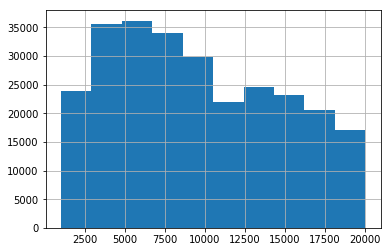

In [343]:
df_carflip['price'].hist()
df_carflip.shape

In [344]:
#drop duplicate rows. usually the clickbait ads looking to buy cars post duplicates
#use a different city to post the same car. will ruin make metrics
df_carflip = df_carflip.drop_duplicates(['desc', 'VIN', 'price', 'year','odometer'],keep='first')

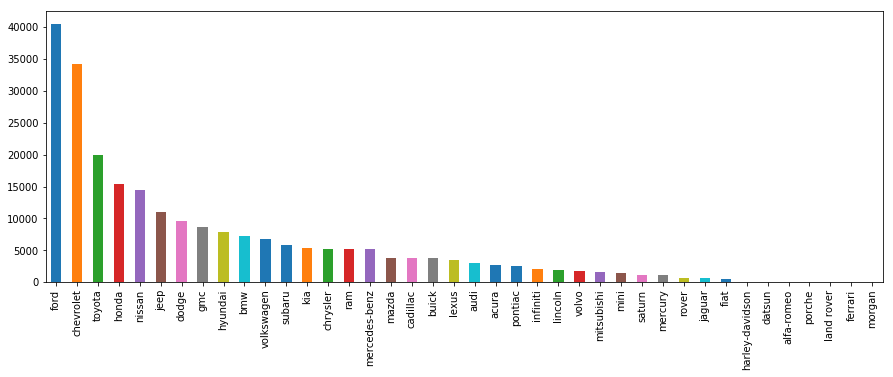

In [447]:
#df_carflip['manufacturer'].value_counts().plot(kind='bar')
plot_bar_chart(df_carflip, 'manufacturer')

In [346]:
df_carflip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238932 entries, 2 to 547757
Data columns (total 22 columns):
url             238932 non-null object
city            238932 non-null object
city_url        238932 non-null object
price           238932 non-null int64
year            238932 non-null float64
manufacturer    238932 non-null object
make            238932 non-null object
condition       149089 non-null object
cylinders       160091 non-null object
fuel            237529 non-null object
odometer        238932 non-null float64
title_status    238932 non-null object
transmission    236906 non-null object
VIN             153981 non-null object
drive           186574 non-null object
size            94950 non-null object
type            193934 non-null object
paint_color     180282 non-null object
image_url       238932 non-null object
desc            238931 non-null object
lat             238664 non-null float64
long            238664 non-null float64
dtypes: float64(4), int64(1),

In [347]:
vc = df_carflip['make'].value_counts(ascending=False).index.tolist()
print('the number of unique makes in the data is {}'. format(len(vc)))

the number of unique makes in the data is 21500


In [348]:
#there are 21500 different makes in the df,
#we will take the top 50 most common makes and 
#change similar makes to match in name. 
for make in vc[:50]:
    df_carflip['make'][df_carflip.make.str.contains(make)] = make

/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [349]:
vc = df_carflip['make'].value_counts(ascending=False).index.tolist()
print('the number of unique makes in the data after matching the top 100: {}'. format(len(vc)))

the number of unique makes in the data after matching the top 100: 14421


In [350]:
#i notice a couple obvious duplicates 
df_carflip['make'][df_carflip.make.str.contains('f-150')] = 'f150'
df_carflip['make'][df_carflip.make.str.contains('f 150')] = 'f150'
df_carflip['make'][df_carflip.make.str.contains('f 250')] = 'f250'
df_carflip['make'][df_carflip.make.str.contains('f-250')] = 'f250'
df_carflip['make'][df_carflip.make.str.contains('f-350')] = 'f350'
df_carflip['make'][df_carflip.make.str.contains('f 350')] = 'f350'


/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/U

In [351]:
#keep only the makes with more than 1000 listings
makecounts = df_carflip['make'].value_counts()
mostcommonmakes_list = makecounts[makecounts>1000].index.tolist()
commonmodels_df = df_carflip[df_carflip['make'].isin(mostcommonmakes_list)]

In [352]:
#keep only the manufacturers with more than 1000 listings
makecounts = commonmodels_df['manufacturer'].value_counts()
mostcommonmakes_list = makecounts[makecounts>1000].index.tolist()
commonmodels_df = commonmodels_df[commonmodels_df['manufacturer'].isin(mostcommonmakes_list)]

In [353]:
#drop rows with describing downpayment, usually the price is a downpayment
commonmodels_df = commonmodels_df[~commonmodels_df.desc.str.contains('Down Payments start', case=False,na=False)]
commonmodels_df = commonmodels_df[~commonmodels_df['desc'].str.contains('low payments', case=False,na=False)]

In [354]:
#drop cars older than 1990 because theyre not worth buying in this price range
#and newer than 2018 because those are junk posts
commonmodels_df = commonmodels_df.query('year > 1990 and year <= 2018')

In [355]:
#drop duplicate descriptions
commonmodels_df = commonmodels_df.drop_duplicates(['desc'],keep='first')

In [356]:
commonmodels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113868 entries, 2 to 547757
Data columns (total 22 columns):
url             113868 non-null object
city            113868 non-null object
city_url        113868 non-null object
price           113868 non-null int64
year            113868 non-null float64
manufacturer    113868 non-null object
make            113868 non-null object
condition       68641 non-null object
cylinders       75421 non-null object
fuel            113276 non-null object
odometer        113868 non-null float64
title_status    113868 non-null object
transmission    112735 non-null object
VIN             74835 non-null object
drive           92040 non-null object
size            44435 non-null object
type            93004 non-null object
paint_color     86111 non-null object
image_url       113868 non-null object
desc            113867 non-null object
lat             113745 non-null float64
long            113745 non-null float64
dtypes: float64(4), int64(1), objec

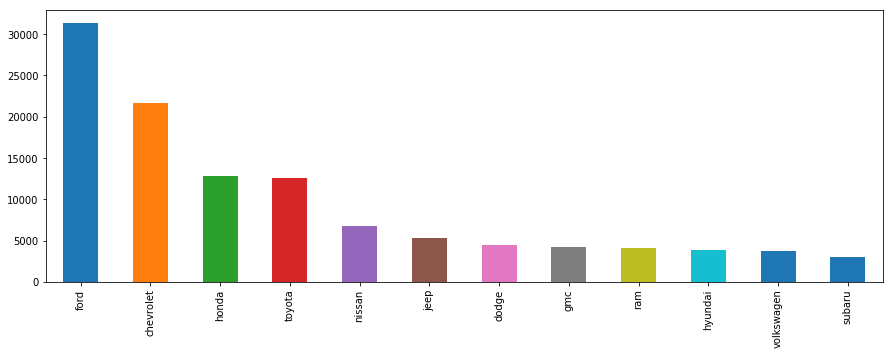

In [448]:

#commonmodels_df['manufacturer'].value_counts().plot(kind='bar')
plot_bar_chart(commonmodels_df, 'manufacturer')

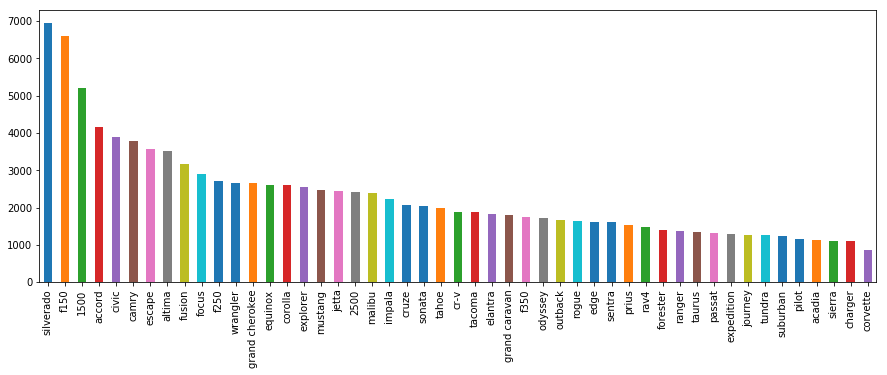

In [449]:
#commonmodels_df['make'].value_counts().plot(kind='bar', figsize=(15,5))
plot_bar_chart(commonmodels_df, 'make')

In [219]:
silerado_f150_df = commonmodels_df.query('make == "silverado" or make == "f150"')

In [220]:
silerado_f150_df.shape

(14072, 22)

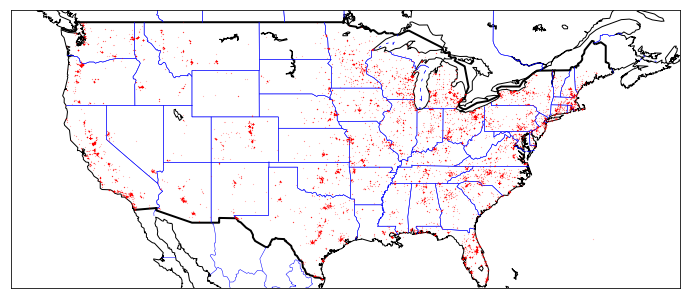

In [177]:
#where can you find silverados and f150s?
plt.figure(figsize=(12,6))
m = Basemap(projection='mill',
            llcrnrlat = 25,
            llcrnrlon = -130,
            urcrnrlat = 50,
            urcrnrlon = -60,
            resolution='l')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
i = 0
for index, row in silerado_f150_df.iterrows():
    lat = row['lat']
    lon = row['long']
    xpt, ypt = m(lon, lat)
    m.plot(xpt,ypt,'.',markersize=0.2,c="red")
    # stopping criteria
    #i = i + 1
    #if (i == 10): break

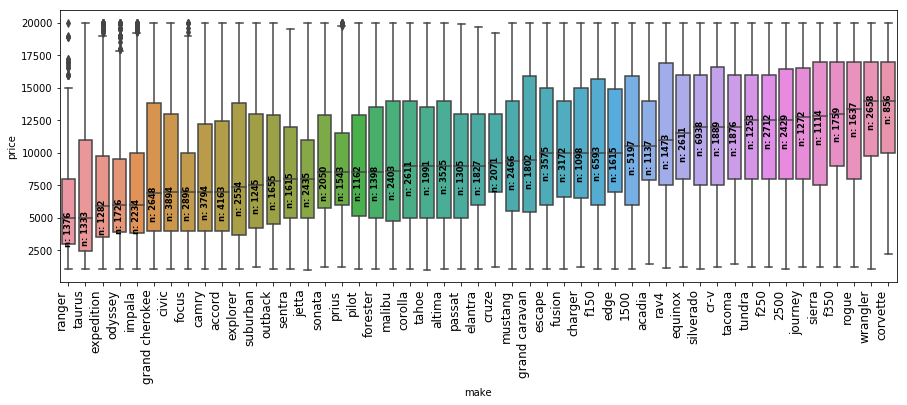

In [359]:
#box plot chart of all the makes side by side
testerframe = commonmodels_df.groupby(['make'])['price'].median().sort_values(ascending=True)
order_of_box = testerframe.index.get_level_values('make').tolist()
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="make", y="price", data=commonmodels_df, order = order_of_box)
 
#Calculate number of obs per group & median to position labels
medians = commonmodels_df.groupby(['make'])['price'].median().sort_values(ascending=True).values
temp_dict = commonmodels_df['make'].value_counts().to_dict()
temp_list = []
for boxmake in order_of_box:
    for make, count in temp_dict.items():
        if boxmake == make:
            temp_list.append(count)
nobs = [str(x) for x in temp_list]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], nobs[tick],
    horizontalalignment='center', size='small', color='black', weight='semibold', rotation=90)



ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=12);
plt.show()


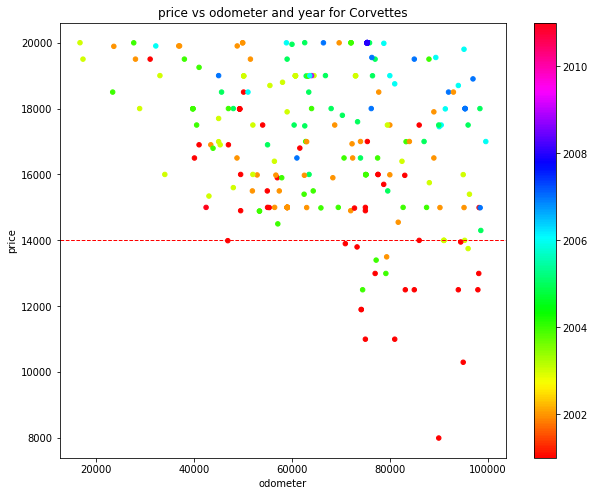

In [363]:
#odometer >1500 and odometer<19800 and price < 9800 and year >2000 and
odo_query_df = commonmodels_df.query('odometer >1500 and odometer<100000 and price < 20000 and year >2000 and make == "corvette"')
median_line = commonmodels_df.query('make == "corvette"')['price'].median()
plt.figure(figsize=(10,8))
plt.scatter(odo_query_df['odometer'],odo_query_df['price'], c=odo_query_df['year'], s=20, cmap=cm.hsv)
plt.xlabel('odometer')
plt.ylabel('price')
plt.title('price vs odometer and year for Corvettes')
cbar= plt.colorbar()
plt.axhline(median_line, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [361]:
odo_query_df.query('price < 10000')

,url,city,city_url,price,year,manufacturer,make,condition,cylinders,fuel,...,transmission,VIN,drive,size,type,paint_color,image_url,desc,lat,long
269507,https://losangeles.craigslist.org/lgb/cto/d/la...,los angeles,https://losangeles.craigslist.org,8000,2001.0,chevrolet,corvette,NaN,8 cylinders,gas,...,automatic,NaN,rwd,NaN,NaN,NaN,https://images.craigslist.org/00l0l_bB7y7waWCo...,2001 Chevrolet Corvette \n\ncondition: good \n...,34.0443,-117.9862


In [362]:
df.loc[269507]['desc']

'2001 Chevrolet Corvette \n\ncondition: good \ncylinders: 8 cylinders \ndrive: rwd \nfuel: gas \nodometer: 90000 \ntitle status: clean \ntransmission: automatic \ntype: coupe \n\n90k miles\nClean title\nRuns absolutely incredible \nPioneer head unit with Bluetooth \nBack up camera \n5.7L 385 horsepower \n\nPlease do not text me \nCalls only 3 2 3 . 2 7 1 . 6 5 0 5\nPRICE IS FIRM!!!\nPRECIO FIRME!!!'

In [365]:
#commonmodels_df[commonmodels_df['desc'].str.contains('low payments', case=False)==True].shape

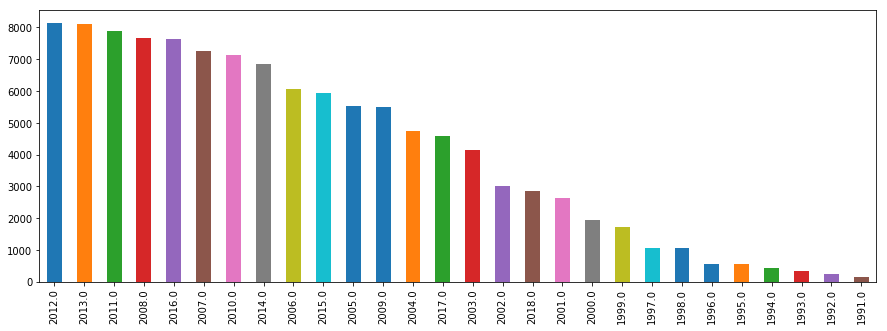

In [450]:
#commonmodels_df['year'].value_counts().plot(kind='bar', figsize=(15,5))
plot_bar_chart(commonmodels_df, 'year')

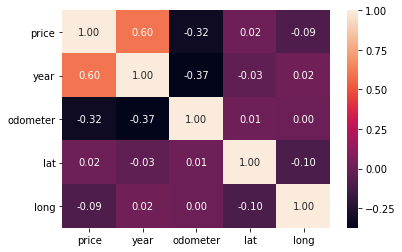

In [367]:
sns.heatmap(commonmodels_df.corr(), annot=True, fmt='.2f')

In [409]:
trystatedf = commonmodels_df
trystatedf['state_code'] = trystatedf['city'].str.split(', ', n = 1, expand = True)[1]

In [512]:
# city_dict = commonmodels_df['city'].value_counts().to_dict()
# state_names = []
# for city, number in city_dict.items():
#     if ',' in city:
#         state_names.append(city.split(', ')[1])

In [430]:
#ADJUST FOR SOME NAMES. SOME STATES NOT REPRESENTED

trystatedf.loc[trystatedf['city'] == 'grand forks', 'state_code'] = 'ND'
trystatedf['city'][trystatedf.city.str.contains('reno')] = 'NV'
trystatedf['city'][trystatedf.city.str.contains('vegas')] = 'NV'
trystatedf['city'][trystatedf.city.str.contains('jersey')] = 'NJ'
trystatedf['city'][trystatedf.city.str.contains('sacramento')] = 'CA'
trystatedf['city'][trystatedf.city.str.contains('sf bay area')] = 'CA'
trystatedf['city'][trystatedf.city.str.contains('fresno / madera')] = 'CA'
trystatedf['city'][trystatedf.city.str.contains('los angeles')] = 'CA'
trystatedf['city'][trystatedf.city.str.contains('san diego')] = 'CA'
trystatedf['city'][trystatedf.city.str.contains('chicago')] = 'IL'
trystatedf['city'][trystatedf.city.str.contains('fort collins / north CO')] = 'CO'
trystatedf['city'][trystatedf.city.str.contains('detroit')] = 'MI'
trystatedf['city'][trystatedf.city.str.contains('tampa')] = 'FL'
trystatedf['city'][trystatedf.city.str.contains('florida')] = 'FL'

trystatedf.loc[trystatedf['city'] == 'NV', 'state_code'] = 'NV'
trystatedf.loc[trystatedf['city'] == 'NJ', 'state_code'] = 'NJ'
trystatedf.loc[trystatedf['city'] == 'CA', 'state_code'] = 'CA'
trystatedf.loc[trystatedf['city'] == 'IL', 'state_code'] = 'IL'
trystatedf.loc[trystatedf['city'] == 'CO', 'state_code'] = 'CO'
trystatedf.loc[trystatedf['city'] == 'FL', 'state_code'] = 'FL'

trystatedf.loc[trystatedf['state_code'] == 'IA/IL', 'state_code'] = 'IA'

trystatedf.loc[trystatedf['city'] == 'albuquerque', 'state_code'] = 'NM'
trystatedf.loc[trystatedf['city'] == 'delaware', 'state_code'] = 'DE'
trystatedf.loc[trystatedf['city'] == 'rhode island', 'state_code'] = 'RI'
trystatedf.loc[trystatedf['city'] == 'hawaii', 'state_code'] = 'HI'
trystatedf.loc[trystatedf['city'] == 'maine', 'state_code'] = 'ME'
trystatedf.loc[trystatedf['city'] == 'new hampshire', 'state_code'] = 'NH'
trystatedf.loc[trystatedf['city'] == 'south dakota', 'state_code'] = 'SD'
trystatedf.loc[trystatedf['city'] == 'north dakota', 'state_code'] = 'ND'
trystatedf.loc[trystatedf['city'] == 'eastern shore', 'state_code'] = 'VA'
trystatedf.loc[trystatedf['city'] == 'vermont', 'state_code'] = 'VT'
trystatedf.loc[trystatedf['city'] == 'wyoming', 'state_code'] = 'WY'




/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vranu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: S

In [429]:
#TO CHECK FOR WHICH STATES ARE NOT REPRESENTED AND FIND THEIR RESPECTIVE DISCTRICTS
nonstate = trystatedf[trystatedf['state_code'].isnull()]
listofnonstate = nonstate['city'].value_counts().index.tolist()
for nonstate in listofnonstate:
    if 'wyoming' in nonstate:
        print nonstate

wyoming


In [431]:
trystatedf['state_code'].value_counts()

CA    8205
FL    5247
NY    4227
MI    4099
TN    3409
NC    3207
WI    3164
OH    3150
TX    3041
OR    2715
VA    2667
MO    2346
PA    2237
CO    2217
NJ    1633
IA    1597
AZ    1550
MT    1520
WA    1476
AL    1393
CT    1381
KY    1285
IL    1218
GA    1181
MN    1162
NV    1105
SC    1090
MD     934
ID     885
AR     791
KS     772
DC     740
ME     713
OK     659
NH     643
RI     635
IN     600
NM     549
VT     543
HI     530
NE     475
DE     356
MA     318
MS     249
WY     242
UT     230
WV     215
LA     164
ND     147
AK     122
SD     101
Name: state_code, dtype: int64

In [422]:
trystatedf.groupby(['state_code'])['price'].median().sort_values(ascending=True)

state_code
RI        6999.0
NJ        7199.0
IN        7200.0
IL        7900.0
VA        7995.0
DE        7997.5
PA        8028.0
CT        8200.0
DC        8420.5
IA/IL     8447.5
OK        8650.0
MA        8694.0
IA        8790.0
OH        8984.5
MS        8988.0
FL        8995.0
NY        8995.0
MI        8995.0
MO        8998.5
KY        9495.0
CA        9499.0
MD        9500.0
GA        9500.0
LA        9525.0
NH        9565.0
UT        9578.5
NM        9750.0
WI        9770.0
NE        9800.0
VT        9895.0
NV        9950.0
AL        9977.0
SC        9995.0
ME        9995.0
KS        9995.0
AZ        9995.0
NC        9995.0
CO       10287.0
TN       10599.0
MN       10689.0
TX       10900.0
OR       10995.0
ID       10995.0
MT       11772.0
HI       11900.0
WV       11950.0
AR       11995.0
WA       12999.0
SD       13400.0
ND       13950.0
AK       14249.5
Name: price, dtype: float64

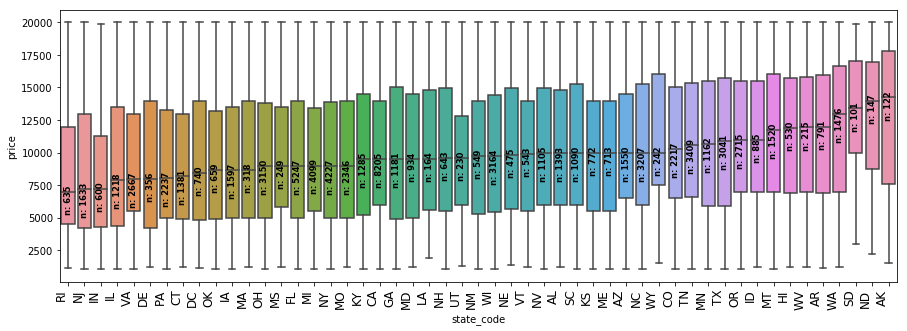

In [432]:
testerframe = trystatedf.groupby(['state_code'])['price'].median().sort_values(ascending=True)
order_of_box = testerframe.index.get_level_values('state_code').tolist()

plt.figure(figsize=(15,5))
ax = sns.boxplot(x="state_code", y="price", data=trystatedf, order = order_of_box)
 
medians = trystatedf.groupby(['state_code'])['price'].median().sort_values(ascending=True).values
temp_dict = trystatedf['state_code'].value_counts().to_dict()
temp_list = []
for boxmake in order_of_box:
    for make, count in temp_dict.items():
        if boxmake == make:
            temp_list.append(count)
nobs = [str(x) for x in temp_list]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], nobs[tick],
    horizontalalignment='center', size='small', color='black', weight='semibold', rotation=90)
    

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=12);
plt.show()

In [433]:
listofstates = trystatedf['state_code'].value_counts().to_dict()
state_count_df = pd.DataFrame(list(listofstates.items()), columns=['state', 'count'])

In [434]:
#sorted(listofstates)
listofstates['WY']

242

In [435]:
state_count_df.sort_values(by=['count'])

,state,count
50,SD,101
13,AK,122
15,ND,147
12,LA,164
4,WV,215
40,UT,230
7,WY,242
46,MS,249
32,MA,318
1,DE,356


In [436]:
len(listofstates)

51

In [443]:
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import pandas as pd

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_count_df['state'],
        z = state_count_df['count'].astype(float),
        locationmode = 'USA-states',
        #text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Vehicles"
        )
    ) ]

layout = dict(
        title = 'July 2019 Vehicles for sale under $20,000 on craigslist',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

#url = py.plot( fig, filename='d3-cloropleth-map' )
iplot(fig)


